# Laboratorio #4 - Familias de Malware

# Parte 1

In [365]:
import os
import pefile
import pandas as pd
import hashlib
import re
from datetime import datetime, timezone
import subprocess

## Creación del dataset

In [366]:
MALWARE_DIR = "./MALWR"
malware_files = [os.path.join(MALWARE_DIR, f) for f in os.listdir(MALWARE_DIR) if os.path.isfile(os.path.join(MALWARE_DIR, f))]

print(f"🔍 Se encontraron {len(malware_files)} archivos de malware en el directorio.")

🔍 Se encontraron 40 archivos de malware en el directorio.


In [367]:
# 📌 Función para calcular SHA-256
def get_sha256(file_path):
    sha256_hash = hashlib.sha256()
    with open(file_path, "rb") as f:
        for byte_block in iter(lambda: f.read(4096), b""):
            sha256_hash.update(byte_block)
    return sha256_hash.hexdigest()

# 📌 Función para extraer timestamps
def convert_timestamp(timestamp):
    try:
        return datetime.fromtimestamp(timestamp, timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
    except (OSError, OverflowError, ValueError):
        return "Invalid Timestamp"

# 📌 API sospechosas
suspicious_api_calls = {
    "process hollowing": {
        "CreateProcess", "GetModuleHandle", "GetProcAddress", "VirtualAllocEx", "WriteProcessMemory", "SetThreadContext", "ResumeThread"
    },
    "create remote thread": {
        "OpenProcess", "GetModuleHandle", "GetProcAddress", "VirtualAllocEx", "WriteProcessMemory", "CreateRemoteThread"
    },
    "enumerating processes": {
        "CreateToolhelp32Snapshot", "Process32First", "Process32Next", "WTSEnumerateProcesses"
    },
    "drop file from PE resource": {
        "GetModuleHandle", "FindResource", "LoadResource", "CreateFileA"
    },
    "IAT hooking": {
        "GetModuleHandle", "strcmp", "VirtualProtect"
    },
    "delete itself": {
        "GetModuleFileName", "ExitProcess", "DeleteFile"
    },
    "download and execute PE file": {
        "URLDownloadToFile", "ShellExecute"
    },
    "bind TCP port": {
        "WSAStartup", "socket"
    },
    "capture network traffic": {
        "socket", "bind", "WSAIoctl", "recvfrom"
    }
}

# 📌 Función para extraer importaciones
def extract_imports(pe):
    imported_functions = []
    imported_dlls = []
    detected_suspicious_apis = set()

    if hasattr(pe, "DIRECTORY_ENTRY_IMPORT"):
        for entry in pe.DIRECTORY_ENTRY_IMPORT:
            dll_name = entry.dll.decode(errors="ignore")
            imported_dlls.append(dll_name)

            for function in entry.imports:
                func_name = function.name.decode(errors="ignore") if function.name else "N/A"
                imported_functions.append(func_name)

                for category, apis in suspicious_api_calls.items():
                    if func_name in apis:
                        detected_suspicious_apis.add(func_name)

    return {
        "DLLs": imported_dlls,
        "Functions": imported_functions,
        "SuspiciousAPIs": list(detected_suspicious_apis)
    }

# 📌 Función para extraer strings sospechosas
def extract_strings(file_path):
    with open(file_path, "rb") as f:
        data = f.read()

    strings = re.findall(b"[ -~]{4,}", data)
    decoded_strings = [s.decode("utf-8", "ignore") for s in strings]

    suspicious_keywords = ["http", "ftp", "cmd", "powershell", "wget", "curl", "0.0.0.0"]
    suspicious_count = sum(1 for s in decoded_strings if any(k in s for k in suspicious_keywords))

    return suspicious_count

def detect_packing_by_size(sections):
    packed_sections = 0
    for section in sections:
        raw_size = section["RawSize"]
        virtual_size = section["VirtualSize"]

        # 📌 Un ejecutable empaquetado suele tener secciones con RawSize muy pequeño y VirtualSize grande
        if raw_size > 0 and virtual_size / raw_size > 10:  # Umbral ajustable
            packed_sections += 1

    return 1 if packed_sections > 0 else 0

In [368]:
def extract_pe_info(file_path):
    try:
        pe = pefile.PE(file_path)
        imports_data = extract_imports(pe)

        # 📌 Evaluar secciones del ejecutable
        section_data = []
        for section in pe.sections:
            section_data.append({
                "Name": section.Name.rstrip(b'\x00').decode(errors="ignore"),
                "RawSize": section.SizeOfRawData,
                "VirtualSize": section.Misc_VirtualSize
            })
        

        pe_info = {
            "Filename": os.path.basename(file_path),
            "SHA256": get_sha256(file_path),
            "TimeDateStamp": convert_timestamp(pe.FILE_HEADER.TimeDateStamp),
            "Subsystem": pe.OPTIONAL_HEADER.Subsystem,
            "NumberOfSections": pe.FILE_HEADER.NumberOfSections,
            "Num_DLLs": len(imports_data["DLLs"]),
            "Num_Imports": len(imports_data["Functions"]),
            "Num_Suspicious_APIs": len(imports_data["SuspiciousAPIs"]),
            "Strings": extract_strings(file_path),
            "Packed_By_Size": detect_packing_by_size(section_data)  # 📌 Nueva evaluación
        }

        pe.close()
        return pe_info

    except Exception as e:
        print(f"⚠️ Error analizando {file_path}: {e}")
        return None

In [369]:
dataset = []
for file in malware_files:
    if not os.path.isfile(file):
        continue
    pe_data = extract_pe_info(file)
    if pe_data:
        dataset.append(pe_data)

df = pd.DataFrame(dataset)

# 📌 Guardar dataset limpio
df.to_csv("malware_dataset_optimized.csv", index=False)
print("✅ Dataset optimizado guardado como 'malware_dataset_optimized.csv'")

# 📌 Mostrar las primeras filas
display(df.head())

✅ Dataset optimizado guardado como 'malware_dataset_optimized.csv'


,Filename,SHA256,TimeDateStamp,Subsystem,NumberOfSections,Num_DLLs,Num_Imports,Num_Suspicious_APIs,Strings,Packed_By_Size
0,JH78C0A33A1B472A8C16123FD696A5CE5EBB,14af57c8a6a37b2fa9bd738285b2951b63fcfb34e1450c...,2009-05-14 17:12:40,2,4,5,62,2,4,0
1,NBV_8B75BCBFF174C25A0161F30758509A44,f52af02529b12c20e45618cae1a38c4ace06f5496ce160...,2009-05-14 17:12:40,2,4,5,62,2,4,0
2,POL55_A4F1ECC4D25B33395196B5D51A06790,57ef37c30a4a10b334a745d2f6235b4703ae99cf8e64e1...,2011-07-29 07:10:31,2,3,7,85,3,5,1
3,6FAA4740F99408D4D2DDDD0B09BBDEFD,a5244829aa94b009e479f06f7ae3e9f40daef32b1570c4...,2009-05-14 17:12:40,2,4,5,62,2,4,0
4,A316D5AECA269CA865077E7FFF356E7D,02e0d550c86910a19ab73ec02bcbe4ed095d683414db2f...,2009-05-14 17:12:40,2,4,5,62,2,4,0


## Exploración y pre-procesamiento de datos

In [370]:
df = pd.read_csv("malware_dataset_optimized.csv")

In [371]:
# Mostrar las primeras filas
display(df.head())

# Revisar los tipos de datos
print("\n📌 Tipos de datos en cada columna:")
print(df.dtypes)

# Revisar valores nulos
print("\n📌 Valores nulos en el dataset:")
print(df.isnull().sum())

# Revisar estadísticas de columnas numéricas
print("\n📌 Resumen estadístico de columnas numéricas:")
print(df.describe())

# Revisar estadísticas de columnas categóricas
print("\n📌 Resumen estadístico de columnas categóricas:")
print(df.describe(include="object"))

,Filename,SHA256,TimeDateStamp,Subsystem,NumberOfSections,Num_DLLs,Num_Imports,Num_Suspicious_APIs,Strings,Packed_By_Size
0,JH78C0A33A1B472A8C16123FD696A5CE5EBB,14af57c8a6a37b2fa9bd738285b2951b63fcfb34e1450c...,2009-05-14 17:12:40,2,4,5,62,2,4,0
1,NBV_8B75BCBFF174C25A0161F30758509A44,f52af02529b12c20e45618cae1a38c4ace06f5496ce160...,2009-05-14 17:12:40,2,4,5,62,2,4,0
2,POL55_A4F1ECC4D25B33395196B5D51A06790,57ef37c30a4a10b334a745d2f6235b4703ae99cf8e64e1...,2011-07-29 07:10:31,2,3,7,85,3,5,1
3,6FAA4740F99408D4D2DDDD0B09BBDEFD,a5244829aa94b009e479f06f7ae3e9f40daef32b1570c4...,2009-05-14 17:12:40,2,4,5,62,2,4,0
4,A316D5AECA269CA865077E7FFF356E7D,02e0d550c86910a19ab73ec02bcbe4ed095d683414db2f...,2009-05-14 17:12:40,2,4,5,62,2,4,0



📌 Tipos de datos en cada columna:
Filename               object
SHA256                 object
TimeDateStamp          object
Subsystem               int64
NumberOfSections        int64
Num_DLLs                int64
Num_Imports             int64
Num_Suspicious_APIs     int64
Strings                 int64
Packed_By_Size          int64
dtype: object

📌 Valores nulos en el dataset:
Filename               0
SHA256                 0
TimeDateStamp          0
Subsystem              0
NumberOfSections       0
Num_DLLs               0
Num_Imports            0
Num_Suspicious_APIs    0
Strings                0
Packed_By_Size         0
dtype: int64

📌 Resumen estadístico de columnas numéricas:
       Subsystem  NumberOfSections   Num_DLLs  Num_Imports  \
count       40.0         40.000000  40.000000    40.000000   
mean         2.0          3.800000   5.875000   103.175000   
std          0.0          0.516398   1.522271    73.654038   
min          2.0          3.000000   4.000000    51.000000   


In [373]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_scale = ["NumberOfSections", "Num_DLLs", "Num_Imports", "Num_Suspicious_APIs", "Strings"]

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

print("✅ Columnas numéricas normalizadas correctamente")

✅ Columnas numéricas normalizadas correctamente


In [374]:
df = pd.get_dummies(df, columns=["Subsystem"], prefix="Subsystem")

In [376]:
# Filtrar solo columnas numéricas antes de calcular la correlación
df_numeric = df.select_dtypes(include=['number'])

# Verificar qué columnas quedaron después del filtrado
print("📊 Columnas numéricas en el DataFrame:")
print(df_numeric.columns)

📊 Columnas numéricas en el DataFrame:
Index(['NumberOfSections', 'Num_DLLs', 'Num_Imports', 'Num_Suspicious_APIs',
       'Strings', 'Packed_By_Size'],
      dtype='object')


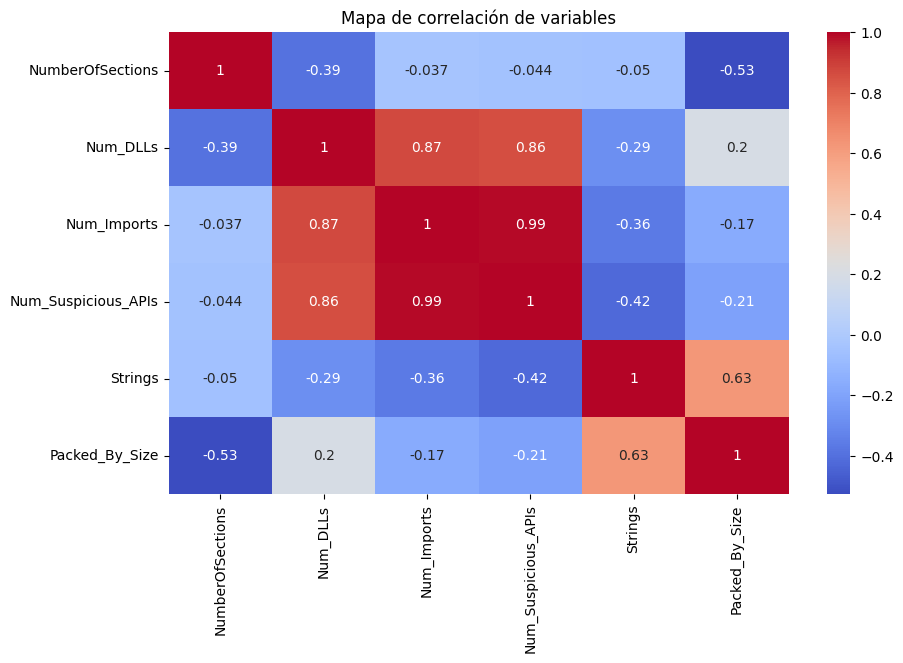

In [377]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm")
plt.title("Mapa de correlación de variables")
plt.show()